In [1]:
from keras import Sequential
from keras.layers import SimpleRNN, LSTM, GRU, Dense, TimeDistributed

In [2]:
import utils
import autoregression as ar
import neural_network as nn

In [3]:
temperature = utils.parse_file('data/pcu1/Supply trafo A winding 2W temp.csv', 'temp')
auxiliaries = utils.parse_file('data/pcu1/AUX ON from PCU.csv', 'aux_on')
current = utils.parse_file('data/pt1/i1.csv', 'I')

In [4]:
X, y = ar.make_design_matrix(auxiliaries, current, temperature, 9)
cols = list(X.columns[2:])
X = utils.scale(X,cols, with_std=True, with_mean=False)
y = utils.scale(y, with_std=True, with_mean=False)
s, u = temperature.std(axis=0), 0 #temperature.mean(axis=0)

aux = auxiliaries.copy()
aux['aux_off'] = 1 - auxiliaries['aux']

curr = current.copy()
curr['I2'] = curr['I']**2
#curr['r'] = curr['I2']*temperature['temp']
cols = ['I', 'I2']
curr[cols] = utils.scale(curr[cols], with_std=True, with_mean=False)

temp = temperature.copy()
temp_mean = temp['temp']
temp = utils.scale(temp, with_std=False, with_mean=True)
s, u = temperature.std(axis=0), temperature.mean(axis=0)

X, y = ar.make_design_matrix(aux, curr, temp, 9)

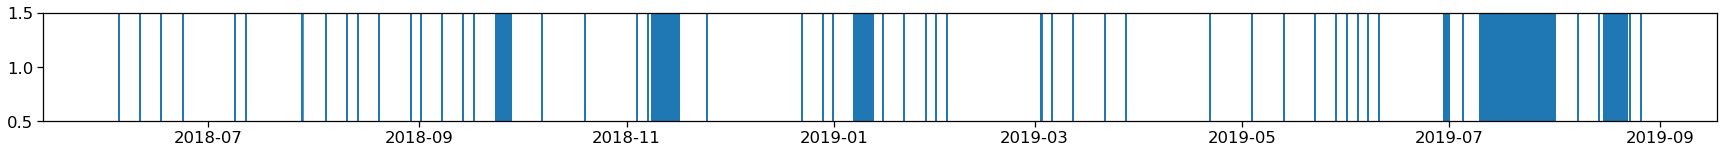

In [5]:
T = utils.sample_gaps(X)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(30,2))
#axes.stem(T.index, T['gap'], markerfmt=' ', basefmt=' ')
axes.eventplot(T.index, orientation='horizontal')
axes.set_ylim(.5,1.5)
plt.show()

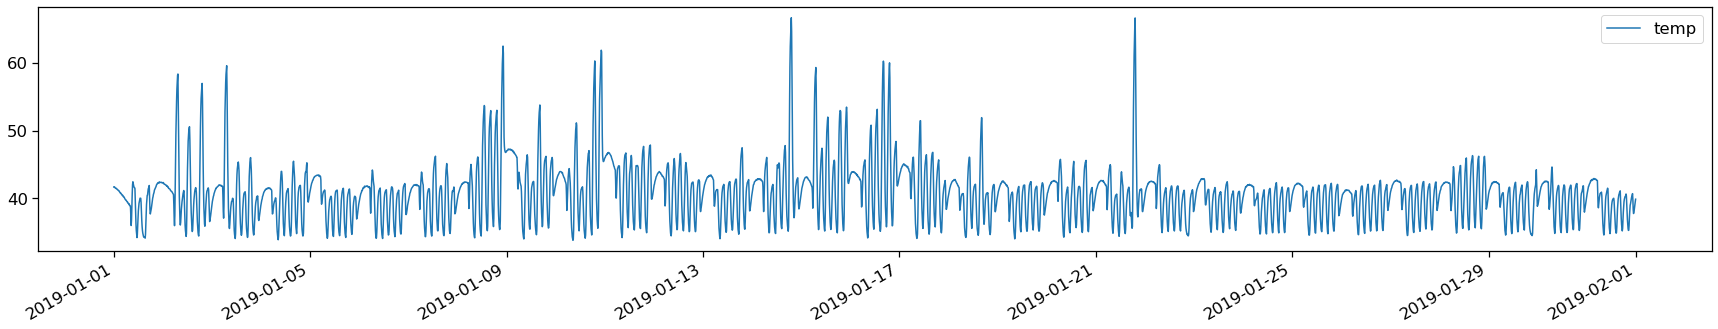

In [6]:
temperature['2019-01-01 00:00:00':'2019-02-01 00:00:00'].plot(figsize=(30,5))
plt.show()

b = ar.ols(X, y, start=None, end='2018-09-01 00:00:00')
b

R2=0.849


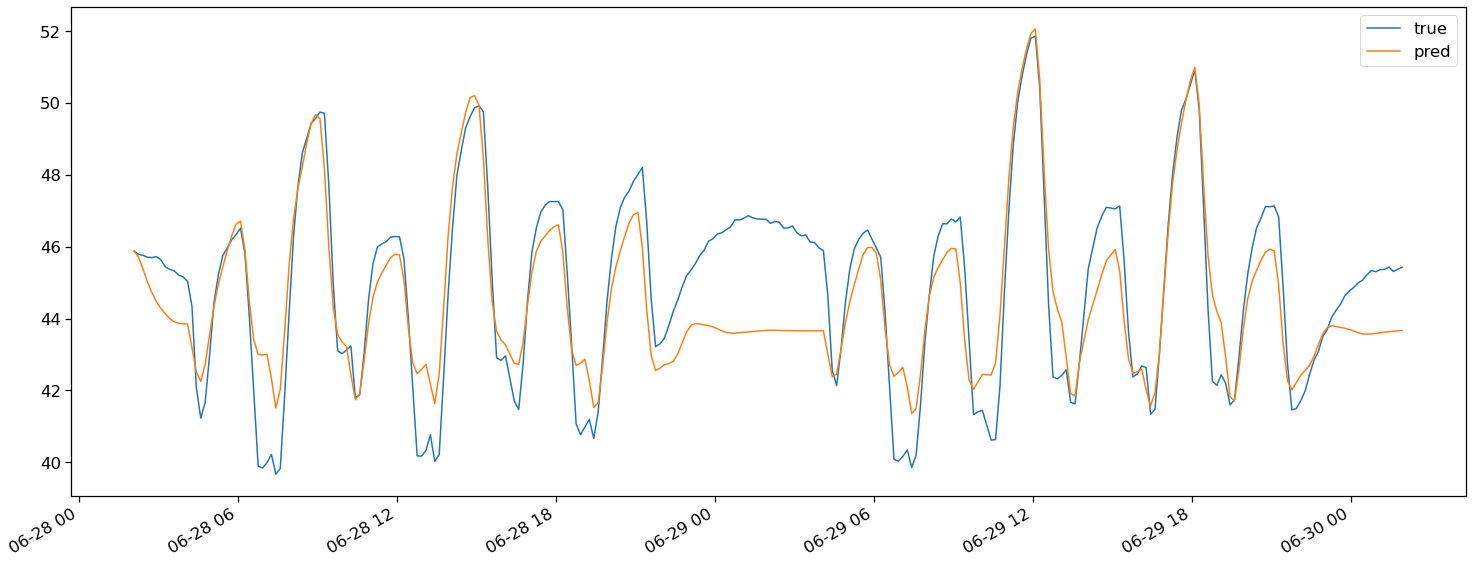

In [7]:
b = ar.ols(X, y, start=None, end='2018-08-01 00:00:00')

start = '2018-06-28 02:00:00'
end = '2018-12-29 22:00:00'
end = np.datetime64(start) + np.timedelta64(2, 'D')

y_true = y[start:end]
y_pred = ar.evaluate(b, X, y[start:end]['temp'][0], start=start, end=end)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25,10))
ax = axes
(y_true*s+u).plot(ax=ax)
(y_pred*s+u).plot(ax=ax)

r2 = skl.metrics.r2_score(y_true.between_time('04:00:00', '22:00:00'), y_pred.between_time('04:00:00', '22:00:00'))
#r2 = skl.metrics.r2_score(y_true, y_pred)
print(f'R2={r2:.3f}')

ax.legend(['true', 'pred'])
plt.show()

In [5]:
def reshape(X, y, batch_size):
    n, p = X.shape
    features = np.empty((n-batch_size, batch_size, p))
    targets = np.empty((n-batch_size, batch_size, 1))
    for i in range(n-batch_size):
        features[i,:,:] = X[i:i+batch_size,:]
        targets[i,:,0] = y[i:i+batch_size,0]
    return features, targets

def reshape2(X, y, batch_size):
    n, p = X.shape
    features = np.empty((n-batch_size, batch_size, p))
    targets = np.empty((n-batch_size, 1, 1))
    for i in range(n-batch_size):
        features[i,:,:] = X[i:i+batch_size,:]
        targets[i,0,0] = y[i+batch_size,0]
    return features, targets

In [6]:
X, y = nn.make_design_matrix(auxiliaries, current, temperature)

In [283]:
start=None
end='2018-06-12 00:00:00'
X_train, y_train = X[start:end].to_numpy(), y[start:end].to_numpy()
n, p = X_train.shape

start='2018-08-01 00:00:00'
end='2018-08-08 00:00:00'
X_test, y_test = X[start:end].to_numpy(), y[start:end].to_numpy()
X_train.shape, X_test.shape

((1068, 2), (1001, 2))

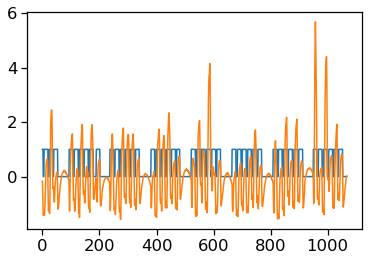

In [388]:
scaler = skl.preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled[:,0] = X_train[:,0]
X_test_scaled[:,0] = X_test[:,0]

#s, u = y_train.std(), y_train.mean()
scaler.fit(y_train)
y_train_scaled = scaler.transform(y_train)
y_test_scaled = scaler.transform(y_test)

scaler = skl.preprocessing.StandardScaler()
scaler.fit(y_train_scaled)
y_train_scaled = scaler.transform(y_train_scaled)
y_test_scaled = scaler.transform(y_test_scaled)

plt.plot(X_train_scaled[:,0])
plt.plot(y_train_scaled[:,0])
plt.show()

In [407]:
batch_size = 24
X_train_reshaped, y_train_reshaped = reshape2(X_train_scaled, y_train_scaled, batch_size)
X_test_reshaped, y_test_reshaped = reshape2(X_test_scaled, y_test_scaled, batch_size)

In [408]:
import sklearn
def loss(y_true, y_pred):
    #print(y_true.shape, y_pred.shape)
    return keras.metrics.mean_squared_error(y_true[:, 0, 0], y_pred[:, 0, 0])


model = Sequential([
    GRU(30, return_sequences=True, input_shape=(batch_size, p), dropout=.1, recurrent_dropout=.5, unroll=True),
    GRU(18, return_sequences=False, unroll=True),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_18 (GRU)                 (None, 24, 30)            3060      
_________________________________________________________________
gru_19 (GRU)                 (None, 18)                2700      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 19        
Total params: 5,779
Trainable params: 5,779
Non-trainable params: 0
_________________________________________________________________


In [425]:
epochs = 10
train_batch_size = 50
model.fit(X_train_reshaped, y_train_reshaped, epochs=epochs, batch_size=train_batch_size, shuffle=False, verbose=True)

Epoch 1/10
21/21 [==============================] - 1s 62ms/step - loss: 0.0984
Epoch 2/10
21/21 [==============================] - 1s 69ms/step - loss: 0.0749
Epoch 3/10
21/21 [==============================] - 2s 77ms/step - loss: 0.0734
Epoch 4/10
21/21 [==============================] - 2s 86ms/step - loss: 0.0897
Epoch 5/10
21/21 [==============================] - 2s 97ms/step - loss: 0.0950
Epoch 6/10
21/21 [==============================] - 2s 102ms/step - loss: 0.1223
Epoch 7/10
21/21 [==============================] - 2s 106ms/step - loss: 0.1306
Epoch 8/10
21/21 [==============================] - 2s 91ms/step - loss: 0.1210
Epoch 9/10
21/21 [==============================] - 2s 101ms/step - loss: 0.0999
Epoch 10/10
21/21 [==============================] - 2s 92ms/step - loss: 0.1123


R2=0.919, MSE=8.118e-02


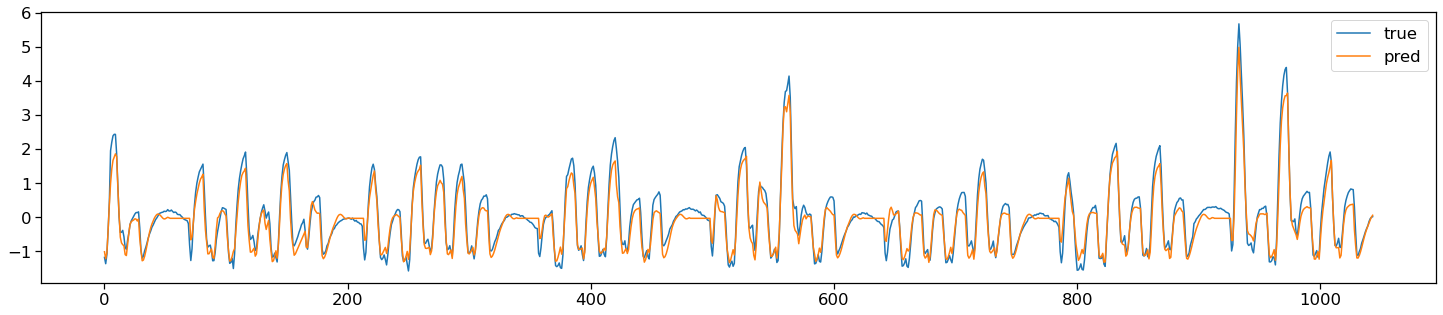

In [426]:
y_pred = model.predict(X_train_reshaped)
y_pred_first = y_pred.reshape(-1,1)
y_true = y_train_reshaped[:,0,0]

r2 = skl.metrics.r2_score(y_true, y_pred_first)
mse = skl.metrics.mean_squared_error(y_true, y_pred_first)
print(f'R2={r2:.3f}, MSE={mse:.3e}')

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25,5))
ax = axes
ax.plot(y_true)
ax.plot(y_pred_first)

ax.legend(['true', 'pred'])
plt.show()

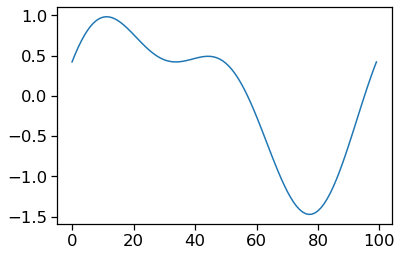

In [218]:
n = 100
p = 2
x = np.linspace(0,2*np.pi, n)
seq1 = np.sin(x)
seq2 = np.sin(2*x + 1)
y = seq1 + .5*seq2
plt.plot(y)

In [219]:
y.shape

(100,)

In [220]:
X = np.array([seq1, seq2]).T
X.shape

(100, 2)

In [221]:
X = X.reshape(n, 1, p)
X.shape

(100, 1, 2)

In [246]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(3, return_sequences=True, input_shape=(1, p)))
model.add(keras.layers.LSTM(1))
model.add(keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_65 (LSTM)               (None, 1, 10)             520       
_________________________________________________________________
lstm_66 (LSTM)               (None, 1)                 48        
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 2         
Total params: 570
Trainable params: 570
Non-trainable params: 0
_________________________________________________________________


In [247]:
epochs = 10
batch_size = 25
model.fit(X, y, epochs=epochs, batch_size=batch_size, shuffle=False, verbose=False)

ValueError: in user code:

    /home/olav/anaconda3/envs/fys-stk4155/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /home/olav/anaconda3/envs/fys-stk4155/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/olav/anaconda3/envs/fys-stk4155/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/olav/anaconda3/envs/fys-stk4155/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/olav/anaconda3/envs/fys-stk4155/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:531 train_step  **
        y_pred = self(x, training=True)
    /home/olav/anaconda3/envs/fys-stk4155/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:885 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /home/olav/anaconda3/envs/fys-stk4155/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:176 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_39 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 2]


In [228]:
nt = 5
y_pred = model.predict(X[:nt,:,:])
r2 = skl.metrics.r2_score(y[:nt], y_pred)
print(f'R2={r2:.3f}')

R2=0.533
